## CoLA - Corpus of Linguistic Acceptability : Is the sentence gramatically correct?

### Importing the libraries

In [2]:
import pickle
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, SequentialSampler
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

### Checking if cuda device is available

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A4000


### Loading the dataset

In [4]:
dataset = load_dataset('glue', 'cola')
dataset

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

### Using the tokenizer from huggingface

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gchhablani/bert-base-cased-finetuned-cola")

### Loading the pre-trained and fine-tuned models from huggingface and moving them to device

In [6]:
preTrainedModel = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels = 2,
                                                      output_attentions = True,
                                                      output_hidden_states = True,)
preTrainedModel.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [6]:
fineTunedModel = AutoModelForSequenceClassification.from_pretrained("gchhablani/bert-base-cased-finetuned-cola")
fineTunedModel.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Creating dataloaders

In [20]:
tokenised_dataset = tokenizer(dataset['train']['sentence'], truncation = True, padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['train']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
train_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [7]:
tokenised_dataset = tokenizer(dataset['test']['sentence'], truncation = True, padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['test']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
test_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [11]:
def getCLSHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i][:,0,:].to("cpu")
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i][:,0,:].to("cpu")
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates

In [ ]:
hiddenStates = getCLSHiddenStates(preTrainedModel, train_dataloader)
preTrainedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
preTrainedCLSHiddenStatesTrain.shape

In [ ]:
hiddenStates = getCLSHiddenStates(fineTunedModel, train_dataloader)
fineTunedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
fineTunedCLSHiddenStatesTrain.shape

In [12]:
hiddenStates = getCLSHiddenStates(preTrainedModel, test_dataloader)
preTrainedCLSHiddenStatesTest = torch.stack(hiddenStates, dim = 0)
preTrainedCLSHiddenStatesTest.shape

torch.Size([13, 1063, 768])

In [ ]:
hiddenStates = getCLSHiddenStates(fineTunedModel, test_dataloader)
fineTunedCLSHiddenStatesTest = torch.stack(hiddenStates, dim = 0)
fineTunedCLSHiddenStatesTest.shape

### Forming logistic regression at all layers of the pre-trained model and fine-tuned model. We can use the classifier at last layer for the fine-tuned model

In [19]:
sc_x = StandardScaler()
for i in range(13):
    xtrain = sc_x.fit_transform(preTrainedCLSHiddenStatesTrain[i])
    xtest = sc_x.fit_transform(preTrainedCLSHiddenStatesTest[i])
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label']) 
    
    preTrain_pred=logreg.predict(xtest)
    filename = 'p{0}/CoLA.tsv'.format(i)
    result = pd.DataFrame(preTrain_pred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)
    
    
    xtrain = sc_x.fit_transform(fineTunedCLSHiddenStatesTrain[i]) 
    xtest = sc_x.fit_transform(fineTunedCLSHiddenStatesTest[i])
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label'])
    
    fineTuned_pred=logreg.predict(xtest)
    filename = 'f{0}/CoLA.tsv'.format(i)
    result = pd.DataFrame(fineTuned_pred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)

### Finding the last layer accuracy of the fine-tuned model

In [20]:
params = list(fineTunedModel.named_parameters())
dense = torch.nn.Linear(768, 768,device=device, bias = True)
activation = torch.nn.Tanh()
dropout = torch.nn.Dropout(p=0.1)
classifier = torch.nn.Linear(in_features=768, out_features=2,  bias = True)
with torch.no_grad():
    dense.weight = params[-4][1]
    dense.bias = params[-3][1]
    classifier.weight = params[-2][1]
    classifier.bias = params[-1][1]

pooled_output = activation(dense(fineTunedCLSHiddenStatesTest[-1,:,:].to('cuda:0')))
dropout_op = dropout(pooled_output)
logits = classifier(dropout_op)
predictions = torch.argmax(logits, dim = 1)

In [21]:
predictions = predictions.to('cpu')
filename = 'CoLA.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

In [9]:
def getLabels(model, data_loader):
    predictions = []
    for batch in data_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            results = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, return_dict=True)
            logits = results.logits
            pred = torch.argmax(logits, dim = 1)
            predictions.extend(pred.tolist())
    return predictions

In [10]:
import numpy as np
import pandas as pd
predictions = getLabels(fineTunedModel, test_dataloader)
filename = 'CoLA.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Getting hidden states averaged over the sequence length for calculating the CKA metric

In [8]:
def getHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i].to("cpu").mean(dim = 1)
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [13]:
hiddenStates = getHiddenStates(preTrainedModel, test_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_CoLA.pt')
preTrainedHiddenStates.shape

torch.Size([13, 1063, 768])

In [14]:
hiddenStates = getHiddenStates(fineTunedModel, test_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_CoLA.pt')
fineTunedHiddenStates.shape

torch.Size([13, 1063, 768])

### Finding Layer-wise CKA

In [15]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [16]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 14)
plt.yticks(np.arange(0,13), fontsize = 14)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(cka_matrix[x][y], xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained BERT', fontsize = 17)
plt.xlabel('Fine-tuned BERT', fontsize = 17)

#fig.colorbar(im)

plt.tight_layout()

plt.show()

In [ ]:
preTrained_cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = preTrainedHiddenStates[j].to(device)
        preTrained_cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(preTrained_cka_matrix, 'CoLA-preTrained_cka_matrix.pt')
preTrained_cka_matrix = preTrained_cka_matrix.numpy()

In [ ]:
fineTuned_cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = fineTunedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        fineTuned_cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(preTrained_cka_matrix, 'CoLA-fineTuned_cka_matrix.pt')
fineTuned_cka_matrix = fineTuned_cka_matrix.numpy()

In [ ]:
plt.rcParams["figure.figsize"] = [10,8]
im = plt.imshow(preTrained_cka_matrix, cmap="inferno")
plt.colorbar(im)
plt.xticks(np.arange(0,13), fontsize = 14)
plt.yticks(np.arange(0,13), fontsize = 14)

preTrained_cka_matrix = np.round(preTrained_cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(str(preTrained_cka_matrix[x][y]), xy=(y, x), horizontalalignment='center',verticalalignment='center')
        
plt.ylabel('Pre-trained BERT', fontsize = 16)
plt.xlabel('Pre-trained BERT', fontsize = 16)
#plt.show()
plt.savefig('CoLA_preTrained_preTrained.pdf')
plt.savefig('CoLA_preTrained_preTrained.jpg')

In [ ]:
plt.rcParams["figure.figsize"] = [10,8]
im = plt.imshow(fineTuned_cka_matrix, cmap="inferno")
plt.colorbar(im)
plt.xticks(np.arange(0,13), fontsize = 14)
plt.yticks(np.arange(0,13), fontsize = 14)

fineTuned_cka_matrix = np.round(fineTuned_cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(str(fineTuned_cka_matrix[x][y]), xy=(y, x), horizontalalignment='center',verticalalignment='center')
        
plt.ylabel('Fine-tuned BERT', fontsize = 16)
plt.xlabel('Fine-tuned BERT', fontsize = 16)
#plt.show()
plt.savefig('CoLA_fineTuned_fineTuned.pdf')
plt.savefig('CoLA_fineTuned_fineTuned.jpg')

In [15]:
fineTunedHiddenStates = fineTunedHiddenStates.to(device)
preTrainedHiddenStates = preTrainedHiddenStates.to(device)

### Calculating layerwise STIR

In [6]:
preTrainedHiddenStates = torch.load('./preTrainedHiddenStates_CoLA.pt').to(device)
fineTunedHiddenStates  = torch.load('./fineTunedHiddenStates_CoLA.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 1063, 768]) torch.Size([13, 1063, 768])


In [8]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [9]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [10]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [11]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [12]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [13]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

In [14]:
STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

In [15]:
STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

In [16]:
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

STIRm2m1: [0.97162706 0.9002426  0.8551921  0.8108857  0.76160544 0.7219206
 0.7194023  0.71629214 0.70217174 0.6799055  0.25305527 0.12996261
 0.07835429]
STIRm1m2: [0.97168106 0.9001976  0.8542921  0.8093025  0.74558455 0.70273286
 0.68797266 0.6813809  0.6792315  0.66904587 0.62074107 0.58728826
 0.5479833 ]
CKA: [0.9999998  0.9993356  0.9860739  0.9824091  0.9432188  0.91374457
 0.91174287 0.9161419  0.92472905 0.8991597  0.45346132 0.2610717
 0.14807746]


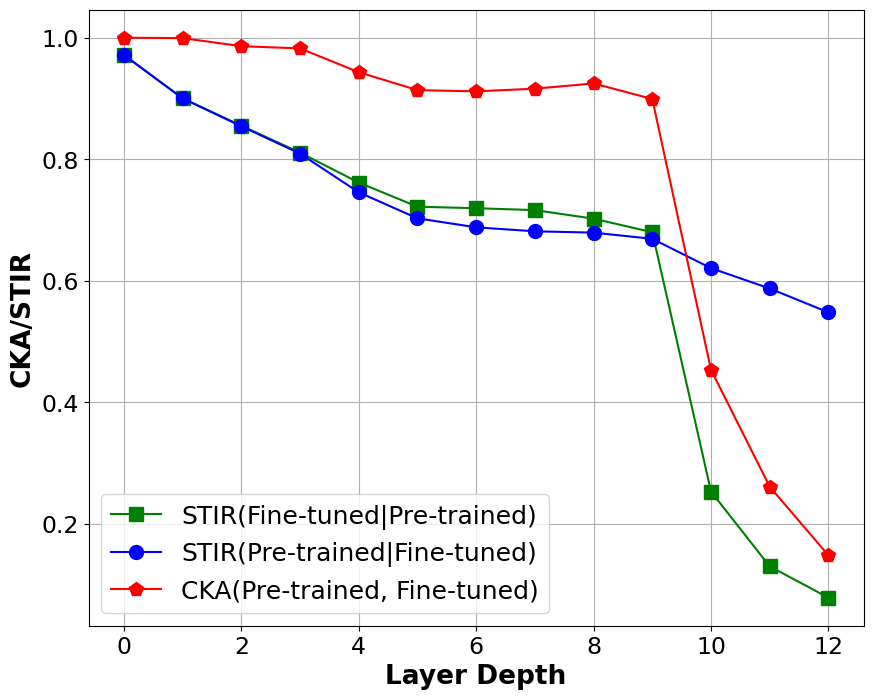

In [6]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=18)
plt.xlabel('Layer Depth', fontsize = 19, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 19, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.tight_layout()
#plt.show()
plt.savefig('CoLA STIR.pdf', bbox_inches='tight')
plt.savefig('CoLA STIR.jpg', bbox_inches='tight')



### Text perturbations

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

### Removing first word

In [ ]:
train_s = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['train']['sentence']]
test_s = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test']['sentence']]

### Removing last word

In [31]:
train_sentences = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['train']['sentence']]
test_sentences = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test']['sentence']]

### Removing nouns and verbs

In [7]:
import nltk
from nltk import pos_tag

def remove_nouns(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'NN' and pos != 'NNP' and pos != 'NNS']
    return ' '.join(filtered_sentence)

def remove_verbs(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
    return ' '.join(filtered_sentence)

### Swap text

In [14]:
import nltk
import random
from nltk.tokenize import word_tokenize

def random_swap_words(sentence):
    words = word_tokenize(sentence)
    if len(words) >= 2:
        i, j = random.sample(range(len(words)), 2)
        words[i], words[j] = words[j], words[i]
        return " ".join(words)
    else:
        return sentence



train_s = [random_swap_words(sentence) for sentence in dataset['train']['sentence']]
test_s = [random_swap_words(sentence) for sentence in dataset['test']['sentence']]

print("Original Sentences:")
print(dataset['train']['sentence'][:5])
print("\nRandomly Swapped Sentences:")
print(train_s[:5])


Original Sentences:
["Our friends won't buy this analysis, let alone the next one we propose.", "One more pseudo generalization and I'm giving up.", "One more pseudo generalization or I'm giving up.", 'The more we study verbs, the crazier they get.', 'Day by day the facts are getting murkier.']

Randomly Swapped Sentences:
["Our let wo n't buy this analysis , friends alone the next one we propose .", "One more 'm generalization and I pseudo giving up .", "One more pseudo or generalization I 'm giving up .", 'The more we study verbs , crazier the they get .', 'the by day Day facts are getting murkier .']


### Add text

In [32]:
import random
from faker import Faker
from typing import List

def add_random_words(sentences: List[str]):
    fake = Faker()
    new_sentences = []
    for sentence in sentences:
        words = sentence.split()
        num_words_to_add = int(len(words) / 5)
        for i in range(num_words_to_add):
            insert_index = random.randint(0, len(words) - 1)
            words.insert(insert_index, fake.word())
        new_sentences.append(" ".join(words))
    return new_sentences

train_s = add_random_words(dataset['train']['sentence'])
test_s = add_random_words(dataset['test']['sentence'])

print("Original Sentences:")
print(dataset['train']['sentence'][:10])
print("\nRandomly added Sentences:")
print(train_s[:10])

Original Sentences:
["Our friends won't buy this analysis, let alone the next one we propose.", "One more pseudo generalization and I'm giving up.", "One more pseudo generalization or I'm giving up.", 'The more we study verbs, the crazier they get.', 'Day by day the facts are getting murkier.', "I'll fix you a drink.", 'Fred watered the plants flat.', 'Bill coughed his way out of the restaurant.', "We're dancing the night away.", 'Herman hammered the metal flat.']

Randomly added Sentences:
["Our friends won't buy this analysis, let alone stay the next one speech we propose.", "One more pseudo generalization and I'm capital giving up.", "One more pseudo generalization or major I'm giving up.", 'The more we study your verbs, the crazier they get.', 'Day argue by day the facts are getting murkier.', "I'll to fix you a drink.", 'Fred shoulder watered the plants flat.', 'Bill travel coughed his way out of the restaurant.', "choose We're dancing the night away.", 'Herman hammered whatever t

### Change Char

In [5]:
import random
import string

def replace_characters(sentence, probability=0.10):
    new_sentence = ""
    for char in sentence:
        if random.random() < probability:
            char = random.choice(string.ascii_letters)
        new_sentence += char
    return new_sentence

train_s = [replace_characters(sentence) for sentence in dataset['train']['sentence']]
test_s = [replace_characters(sentence) for sentence in dataset['test']['sentence']]

print("Original Sentences:")
print(dataset['train']['sentence'][:5])
print("\nRandomly Swapped Sentences:")
print(train_s[:5])


Original Sentences:
["Our friends won't buy this analysis, let alone the next one we propose.", "One more pseudo generalization and I'm giving up.", "One more pseudo generalization or I'm giving up.", 'The more we study verbs, the crazier they get.', 'Day by day the facts are getting murkier.']

Randomly Swapped Sentences:
["bur fxiWnds woR't buy tCis pnayysis, let alone thx next onetwe ppoposeA", "OneWmore pseudo generaliVation andxI'mdgiLing up.", "OPe mFre pseudo ganeralizatiox or I'm giving up.", 'The more we stuOZ verbs, the crazier thBy get.', 'pay by day the bactt are hettinglmurkNer.']


### Bias

In [10]:
def changeGender(str):
    dictionary = {
    "batman": "batwoman", "batwoman": "batman",
    "boy": "girl", "girl": "boy",
    "boyfriend": "girlfriend", "girlfriend": "boyfriend",
    "father": "mother", "mother": "father",
    "husband": "wife", "wife": "husband",
    "he": "she", "she": "he",
    "his": "her", "her": "his",
    "male": "female", "female": "male",
    "man": "woman", "woman": "man",
    "Mr": "Ms", "Mr": "Ms",
    "sir": "madam", "madam": "sir",
    "son": "daughter", "daughter": "son",
    "uncle": "aunt", "aunt": "uncle",
    }

    str = str + ' ' # Append a space at the en
    temp = ""
    ans = ""

    for i in range(len(str)):
        if str[i] != ' ':
            temp += str[i]
        else:
            if temp in dictionary:
                temp = dictionary[temp]

            ans = ans + temp + ' '
            temp = ""

    return ans

train_s = [changeGender(sentence) for sentence in dataset['train']['sentence']]
test_s = [changeGender(sentence) for sentence in dataset['test']['sentence']]

print("Original Sentences:")
print(dataset['train']['sentence'][:10])
print("\nRandomly Swapped Sentences:")
print(train_s[:10])


Original Sentences:
["Our friends won't buy this analysis, let alone the next one we propose.", "One more pseudo generalization and I'm giving up.", "One more pseudo generalization or I'm giving up.", 'The more we study verbs, the crazier they get.', 'Day by day the facts are getting murkier.', "I'll fix you a drink.", 'Fred watered the plants flat.', 'Bill coughed his way out of the restaurant.', "We're dancing the night away.", 'Herman hammered the metal flat.']

Randomly Swapped Sentences:
["Our friends won't buy this analysis, let alone the next one we propose. ", "One more pseudo generalization and I'm giving up. ", "One more pseudo generalization or I'm giving up. ", 'The more we study verbs, the crazier they get. ', 'Day by day the facts are getting murkier. ', "I'll fix you a drink. ", 'Fred watered the plants flat. ', 'Bill coughed her way out of the restaurant. ', "We're dancing the night away. ", 'Herman hammered the metal flat. ']


In [69]:
tokenised_dataset = tokenizer(train_s, padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['train']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
train_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [9]:
tokenised_dataset = tokenizer(no_nouns_sentences, padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['test']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
test_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)